# 如何生成任务数据？

**目标**: 通过本指南，您将能够为CANN仿真生成任务输入。

**预计阅读时间**: 10分钟

---

## 介绍

CANN模型需要输入刺激来模拟真实行为——跟踪移动目标、编码空间位置或响应群体编码信号。与其手动创建这些输入，**任务API**提供了常见实验范式的现成生成器。

本指南向您展示如何：
1. 创建平滑追踪任务
2. 生成任务数据
3. 理解任务数据结构
4. 在仿真中使用任务数据

## 什么是任务？

**任务**是为CANN模型生成时变输入刺激的对象。它们处理以下复杂性：
- 创建生物学上真实的输入模式
- 管理时间和持续时间
- 格式化数据以实现高效仿真循环
- 追踪元数据（例如，目标位置、速度）

**关键原则**: 任务**生成输入** → 模型**消耗输入**在仿真循环中。

## 创建平滑追踪任务

最常见的任务是**平滑追踪**，其中刺激在神经群体中平滑移动：


In [1]:
import brainstate
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D
import jax

# 设置环境和模型（来自前面的指南）
brainstate.environ.set(dt=0.1)
cann = CANN1D(num=512)
cann.init_state()

# 创建平滑追踪任务
task = SmoothTracking1D(
    cann_instance=cann,                # 链接到CANN模型
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),  # 外部输入位置（弧度制）
    duration=(10.0, 10.0, 10.0, 10.0), # 每个位置的持续时间（毫秒）
    time_step=brainstate.environ.get_dt()  # 仿真时间步长
)

**发生了什么**:
- `cann_instance`: 任务需要模型实例来访问其`get_stimulus_by_pos()`方法，该方法为给定位置生成空间定位的输入模式。任务还使用模型的结构（神经元位置、网络大小）来创建适当的刺激。
- `Iext`: 刺激将出现的目标位置序列（弧度制，从-π到π）
- `duration`: 刺激在每个位置停留多长时间（毫秒）
- `time_step`: 应与模型的`dt`匹配以保持同步

**重要**: CANN模型必须提供一个`get_stimulus_by_pos(position)`方法，该方法返回给定空间位置的输入模式。任务调用此方法来生成数据。

## 生成数据

创建任务后，生成实际的输入数组：


In [2]:
# 生成所有任务数据
task.get_data()

<SmoothTracking1D> Generating Task data: 400it [00:00, 1798.39it/s]


此方法预计算整个仿真的所有输入刺激。数据存储在`task.data`中。

## 理解任务数据结构

让我们检查任务生成的内容：


In [3]:
print(f"数据形状: {task.data.shape}")
print(f"时间步数: {task.run_steps.shape[0]}")
print(f"时间步长: {task.time_step} ms")
print(f"总仿真时间: {task.run_steps.shape[0] * task.time_step} ms")

数据形状: (400, 512)
时间步数: 400
时间步长: 0.1 ms
总仿真时间: 40.0 ms


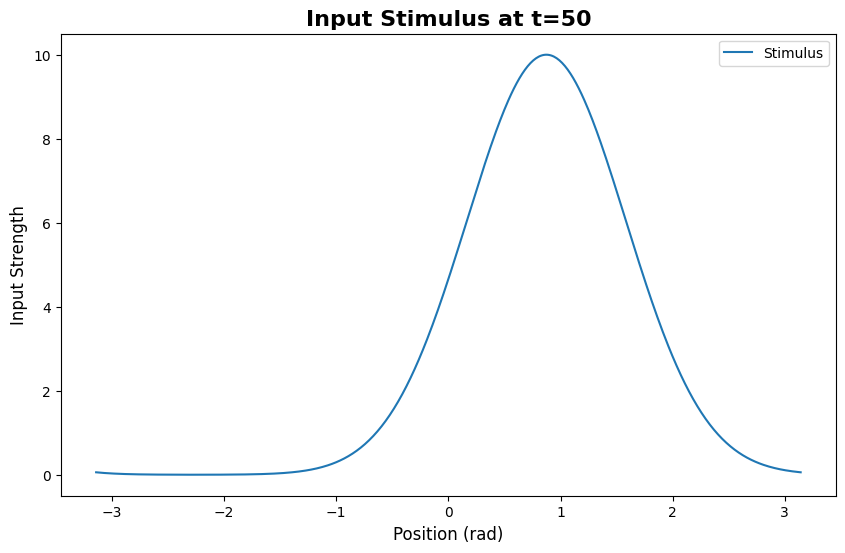

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Input Stimulus at t=50'}, xlabel='Position (rad)', ylabel='Input Strength'>)

In [4]:
from canns.analyzer.plotting import PlotConfigs, energy_landscape_1d_static

# 为静态图创建配置
config = PlotConfigs.energy_landscape_1d_static(
    time_steps_per_second=100,
    title='Input Stimulus at t=50',
    xlabel='Position (rad)',
    ylabel='Input Strength',
    show=True
)

# 绘制时间步50处的输入
energy_landscape_1d_static(
    data_sets={'Stimulus': (cann.x, task.data[50])},
    config=config
)

您将看到以`Iext`位置之一为中心的高斯形凸起。

## 在仿真中使用任务数据

现在将任务数据连接到您的模型仿真：


In [5]:
def run_step(t, stimulus):
    """仿真步骤函数。"""
    cann(stimulus)  # 向模型输入刺激
    return cann.u.value, cann.r.value  # 返回突触输入和活动

# 用任务数据运行仿真
us, rs = brainstate.transform.for_loop(
    run_step,
    task.run_steps,  # 仿真步数
    task.data,       # 任务生成的刺激
    pbar=brainstate.transform.ProgressBar(10)
)

print(f"突触输入形状: {us.shape}")   # (400, 512)
print(f"神经活动形状: {rs.shape}")  # (400, 512)

  0%|          | 0/400 [00:00<?, ?it/s]

突触输入形状: (400, 512)
神经活动形状: (400, 512)


**工作流程**:
1. `task.data`为每个时间步提供刺激
2. `for_loop`遍历时间步
3. 在每一步，刺激被传递给`run_step`
4. 模型更新其状态并返回结果
5. 所有结果被收集到数组中（`us`、`rs`）

## 完整工作示例

这是从模型创建到任务驱动仿真的完整管道：


In [6]:
import brainstate
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D

# 1. 设置
brainstate.environ.set(dt=0.1)

# 2. 创建模型
cann = CANN1D(num=512)
cann.init_state()

# 3. 创建任务
task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),
    duration=(10.0, 10.0, 10.0, 10.0),
    time_step=brainstate.environ.get_dt(),
)
task.get_data()

# 4. 运行仿真
def run_step(t, stimulus):
    cann(stimulus)
    return cann.u.value, cann.r.value

us, rs = brainstate.transform.for_loop(
    run_step,
    task.run_steps,
    task.data,
    pbar=brainstate.transform.ProgressBar(10)
)

print("仿真完成！")
print(f"捕获了{us.shape[0]}个时间步的活动")

<SmoothTracking1D> Generating Task data: 400it [00:00, 9055.94it/s]


  0%|          | 0/400 [00:00<?, ?it/s]

仿真完成！
捕获了400个时间步的活动


## 探索任务参数

`SmoothTracking1D`很灵活。尝试不同的配置：

### 示例1: 快速追踪


In [7]:
task_fast = SmoothTracking1D(
    cann_instance=cann,
    Iext=(0.0, 1.0, 2.0),
    duration=(5.0, 5.0),  # 更短的持续时间=更快的过渡
    time_step=0.1
)

### 示例2: 许多位置


In [8]:
import jax.numpy as jnp

# 跟踪10个均匀间隔的位置
positions = jnp.linspace(-3.0, 3.0, 10)
durations = [8.0] * 9

task_dense = SmoothTracking1D(
    cann_instance=cann,
    Iext=tuple(positions),
    duration=tuple(durations),
    time_step=0.1
)

### 示例3: 可变持续时间


In [9]:
# 每个位置的不同持续时间
task_variable = SmoothTracking1D(
    cann_instance=cann,
    Iext=(0.0, 1.5, -1.0, 2.0),
    duration=(15.0, 5.0, 10.0),  # 在第一个位置停留更长时间
    time_step=0.1
)

## 其他任务类型

虽然本指南重点关注`SmoothTracking1D`，但该库包括其他任务生成器：

- `SmoothTracking2D`: 2D空间追踪
- `PopulationCoding`: 群体编码输入
- `ClosedLoopNavigation`: 具有反馈的交互式导航
- `OpenLoopNavigation`: 预定义的轨迹

所有都遵循相同的模式：
1. 用参数创建任务
2. 调用`task.get_data()`
3. 在仿真循环中使用`task.data`

我们将在完整详情部分中探索这些。

## 常见问题

**问: 生成后我可以修改任务数据吗?**

可以! `task.data`是您可以操纵的JAX数组：


In [10]:
task.get_data()
# 向所有输入添加噪声
task.data = task.data + 0.1 * jax.random.normal(jax.random.PRNGKey(0), task.data.shape)

<SmoothTracking1D> Generating Task data: 400it [00:00, 9381.50it/s]


**问: 如果我想要自定义输入模式怎么办?**

您可以创建任务作为模板并修改它们，或手动生成输入：


In [11]:
import jax.numpy as jnp

# 创建自定义输入序列
custom_data = jnp.zeros((100, 512))
for t in range(100):
    position = jnp.sin(t * 0.1)  # 正弦运动
    custom_data = custom_data.at[t].set(
        jnp.exp(-0.5 * (cann.x - position)**2 / 0.3**2)
    )

**问: 我每次都需要调用`get_data()`吗?**

每个任务实例只需调用一次。数据被缓存：


In [ ]:
task.get_data()  # 生成数据
# ... 在仿真中使用task.data

# 如果您更改参数，请重新创建任务
task_new = SmoothTracking1D(...)
task_new.get_data()

## 后续步骤

现在您可以生成任务数据，您已准备好：

1. **[分析CANN模型动力学](04_how_to_analyze_cann_model.md)** - 可视化能量景观、凸起追踪等
2. **[探索任务生成器](link-to-core-concepts-tasks)** - 了解所有可用任务类型及其用途
3. **[完整任务API参考](link-to-full-details-tasks)** - 所有任务参数和方法的完整文档

---

**快速参考**:


In [ ]:
# 标准任务工作流
from canns.task.tracking import SmoothTracking1D

task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(pos1, pos2, ...),
    duration=(dur1, dur2, ...),
    time_step=dt
)
task.get_data()

# 在仿真中使用
for_loop(run_step, task.run_steps, task.data)

---

*有疑问? 检查[核心概念: 任务生成器](link)或[GitHub讨论](https://github.com/routhleck/canns/discussions)。*